In [103]:
# stdlib
from typing import Any, List

# third party
import numpy as np
import pandas as pd
#from ctgan import CTGAN

# synthcity absolute
from synthcity.plugins.core.dataloader import DataLoader, GenericDataLoader
from synthcity.plugins.core.distribution import Distribution
from synthcity.plugins.core.plugin import Plugin
from synthcity.plugins.core.schema import Schema
from synthcity.plugins.core.distribution import (
    Distribution,
    IntegerDistribution,
)
from tabpfn import TabPFNClassifier
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
#from ForestDiffusion import ForestDiffusionModel
from synthcity.plugins import Plugins
from smote import MySMOTE
from imblearn.over_sampling import SMOTE

In [104]:
torch.__version__

'1.13.1+cu117'

In [117]:
class tabpfn_points_plugin(Plugin):
    """TabPFN integration in synthcity."""

    def __init__(
        self,
        n_random_test_samples: int = 3_000,
        device: str = "cuda:0",
        n_batches: int = 200,
        lr: float = 0.1,
        n_permutations: int = 3,
        n_ensembles: int = 3,
        store_intermediate_data: bool = False,
        **kwargs: Any
    ) -> None:
        super().__init__(**kwargs)
        self.n_random_test_samples = n_random_test_samples
        self.device = device
        self.n_batches = n_batches
        self.lr = lr
        self.n_permutations = n_permutations
        self.n_ensembles = n_ensembles
        self.preprocessor = StandardScaler()
        self.store_intermediate_data = store_intermediate_data
        if store_intermediate_data:
            self.loss_list = []
            self.all_X_false_train = []


    @staticmethod
    def name() -> str:
        return "tabpfn_points"

    @staticmethod
    def type() -> str:
        return "debug"

    @staticmethod
    def hyperparameter_space(**kwargs: Any) -> List[Distribution]:
        """
        We can customize the hyperparameter space, and use it in AutoML benchmarks.
        """
        #TODO
        return [
            IntegerDistribution(name="embedding_n_units", low=100, high=500, step=50),
            IntegerDistribution(name="batch_size", low=100, high=300, step=50),
            IntegerDistribution(name="n_iter", low=100, high=500, step=50),
        ]

    def _fit(self, X: DataLoader, X_false_train_init=None, *args: Any, **kwargs: Any) -> "tabpfn_points_plugin":
        if X_false_train_init is None:
            X_false_train = (np.random.rand(512, X.shape[1]) * 4 - 2) / 5.
        else:
            X_false_train = X_false_train_init
        self.X_false_train = torch.tensor(X_false_train).float().to(self.device)
        self.X_false_train.requires_grad = True
        X_true = self.preprocessor.fit_transform(X.numpy()) # all numerical features for now
        X_true = torch.tensor(X_true, dtype=torch.float32).to(self.device)
        X_random_test = np.random.rand(self.n_random_test_samples, X.shape[1]) * 4 - 2
        X_random_test = torch.tensor(X_random_test).float().to(self.device)

        n_test_from_false_train = 512

        optimizer = torch.optim.Adam([self.X_false_train], lr=self.lr)

        tabpfn_classifier = TabPFNClassifier(device=self.device, N_ensemble_configurations=self.n_permutations,
                                              no_preprocess_mode=True, no_grad=False, normalize=False)

        for batch in tqdm(range(self.n_batches)):
            n_train = 512
            n_test = min(2048, X_true.shape[0])
            tabpfn_output_proba_list = []
            for _ in range(self.n_ensembles):
                indices_train = np.random.choice(X_true.shape[0], n_train, replace=False)
                X_batch_train = X_true[indices_train]
                indices_test = np.random.choice(X_true.shape[0], n_test, replace=False)
                X_batch_test = X_true[indices_test]
                #indices_false_test = np.random.choice(X_random_test.shape[0], len(X_batch_test), replace=False)
                #X_false_test = X_random_test[indices_false_test]
                indices_false_test_from_random = np.random.choice(X_random_test.shape[0], len(X_batch_test) - n_test_from_false_train, replace=False)
                X_false_test_from_random = X_random_test[indices_false_test_from_random]
                indices_false_test_from_false_train = np.random.choice(self.X_false_train.shape[0], n_test_from_false_train, replace=False)
                X_false_test_from_false_train = self.X_false_train.detach()[indices_false_test_from_false_train]
                X_false_test = torch.cat((X_false_test_from_random, X_false_test_from_false_train), dim=0)

                indices_false_train = np.random.choice(self.X_false_train.shape[0], len(X_batch_train), replace=False)
                X_false_batch_train = self.X_false_train[indices_false_train]

                X_train = torch.cat((X_batch_train, X_false_batch_train), dim=0)
                X_test = torch.cat((X_batch_test, X_false_test), dim=0)
                y_train = torch.cat((torch.ones(X_batch_train.shape[0]), torch.zeros(X_false_batch_train.shape[0])), dim=0).long()
                y_test = torch.cat((torch.ones(X_batch_test.shape[0]), torch.zeros(X_false_test.shape[0])), dim=0).long()
                #y_test = torch.ones(X_batch_test.shape[0]).long()
                #y_test = torch.zeros(X_false_test.shape[0]).long()

                perm_train = torch.randperm(X_train.shape[0])
                X_train = X_train[perm_train]
                y_train = y_train[perm_train]
                perm_test = torch.randperm(X_test.shape[0])
                X_test = X_test[perm_test]
                y_test = y_test[perm_test]

                # add a third feature to X_train and X_test with random values
                X_train = torch.cat((X_train, torch.randn(X_train.shape[0], 1).to(self.device)), dim=1)
                X_test = torch.cat((X_test, torch.randn(X_test.shape[0], 1).to(self.device)), dim=1)
                tabpfn_classifier.fit(X_train, y_train, overwrite_warning=True)
                tabpfn_output_proba = tabpfn_classifier.predict_proba(X_test)
                tabpfn_output_proba_list.append(tabpfn_output_proba)
            tabpfn_output_proba = torch.stack(tabpfn_output_proba_list).mean(dim=0)

            loss = torch.mean(torch.abs((tabpfn_output_proba[:, 0] - tabpfn_output_proba[:, 1]))**2)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            if self.store_intermediate_data:
                self.loss_list.append(loss.item())
                self.all_X_false_train.append(self.X_false_train.detach().cpu().numpy())
    
        return tabpfn_output_proba.detach().cpu(), self.X_false_train.detach().cpu(), y_test.detach().cpu()

    def sample(self, count: int, **kwargs: Any) -> pd.DataFrame:
        if count > len(self.X_false_train):
            raise ValueError("Requested count exceeds the available data.")
        indices = np.random.choice(len(self.X_false_train), count, replace=False)
        false_points = self.X_false_train[indices].detach().cpu().numpy()
        return self.preprocessor.inverse_transform(false_points)
    
    def _generate(self, count: int, syn_schema: Schema, **kwargs: Any) -> pd.DataFrame:
        return self._safe_generate(self.sample, count, syn_schema)
    

In [118]:
syn_model._fit.__code__

<code object _fit at 0x7f7520b245b0, file "/tmp/ipykernel_5556/3645983390.py", line 49>

In [119]:
from sklearn.datasets import make_moons
X, _ = make_moons(n_samples=1000, noise=0.1)

loader = GenericDataLoader(X)

import matplotlib.pyplot as plt
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader


#syn_model = Plugins().get("tabpfn_points", n_batches=1, lr=0.1, store_intermediate_data=True)
syn_model = tabpfn_points_plugin(n_batches=200, lr=0.1, store_intermediate_data=True)
tabpfn_output_proba, X_false_train, y_test = syn_model._fit(loader)

#false_data = syn_model.generate(512).numpy()
# plt.scatter(false_data[:, 0], false_data[:, 1], alpha=0.1)
# plt.title(method)


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [04:21<00:00,  1.31s/it]


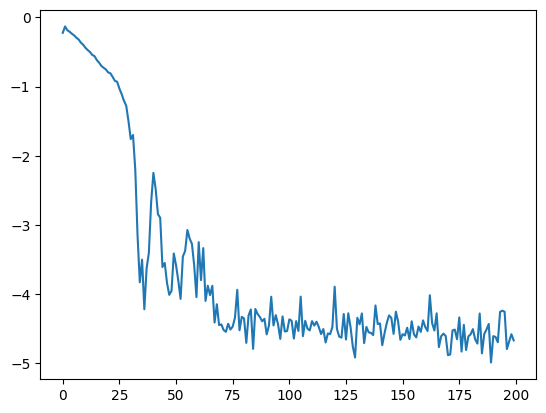

In [120]:
plt.plot(np.log10(syn_model.loss_list))

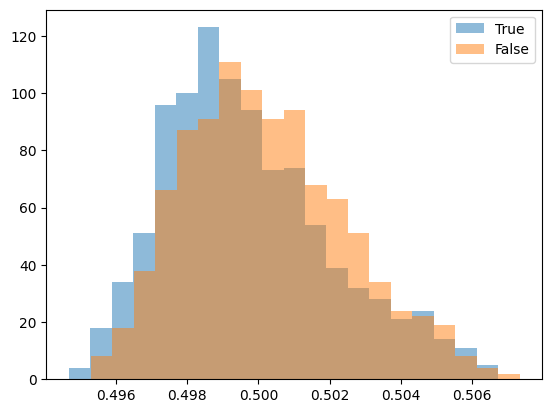

In [121]:
plt.hist(tabpfn_output_proba[y_test==1][:, 0], bins=20, alpha=0.5, label="True")
plt.hist(tabpfn_output_proba[y_test==0][:, 0], bins=20, alpha=0.5, label="False")
plt.legend()

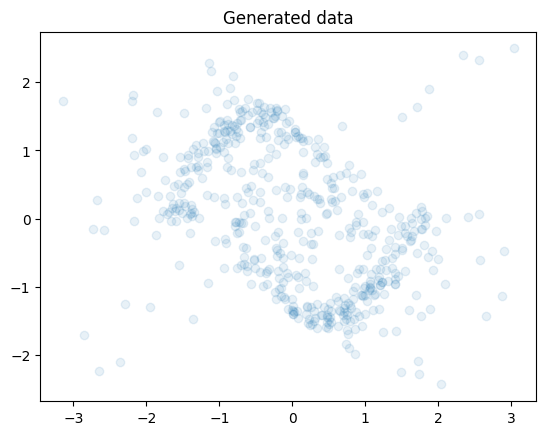

In [122]:
#plt.scatter(X[:, 0], X[:, 1], alpha=0.1)
plt.scatter(X_false_train[:, 0], X_false_train[:, 1], alpha=0.1)
plt.title("Generated data")
plt.show()

In [ ]:
X.shape

(1000, 2)